In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# Configuración general
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 100
batch_size = 64
num_epochs = 200
learning_rate = 0.0002
beta1, beta2 = 0.5, 0.999
data_dir = "D:/SIS-421/smileys_dataset_all"  # Cambia esto a la ruta de tu dataset
output_dir = "D:/SIS-421/verano/imagenesGeneradas1_500Epoch"  # Directorio para guardar imágenes
os.makedirs(output_dir, exist_ok=True)
model_dir = "D:/SIS-421/verano/modelos"  # Directorio para guardar modelos
os.makedirs(model_dir, exist_ok=True)

In [5]:
# Transformaciones y carga del dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizar a rango [-1, 1]
])


In [6]:
from PIL import Image
from torch.utils.data import Dataset

class CustomDataset(Dataset):  # Define una clase llamada CustomDataset que hereda de Dataset
    def __init__(self, root_dir, transform=None):  
        self.root_dir = root_dir  # Almacena el directorio raíz donde se encuentran las imágenes
        self.transform = transform  # Almacena las transformaciones que se aplicarán a las imágenes
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Crea una lista con las rutas de todas las imágenes en el directorio raíz que tienen extensiones .png, .jpg o .jpeg

    def __len__(self):  # Método que devuelve la cantidad de imágenes en el dataset
        return len(self.image_paths)  # Devuelve el número de elementos en la lista de rutas de imágenes

    def __getitem__(self, idx):  # Método que permite acceder a una imagen específica del dataset usando un índice
        img_path = self.image_paths[idx]  # Obtiene la ruta de la imagen en la posición 'idx'
        image = Image.open(img_path).convert("RGB")  # Abre la imagen y la convierte a formato RGB (cambiar a "L" si las imágenes son en escala de grises)
        if self.transform:  # Si se han definido transformaciones
            image = self.transform(image)  # Aplica las transformaciones a la imagen
        return image, 0  # Devuelve la imagen transformada y un valor 0 (puede ser una etiqueta o un marcador de posición)  # El 0 es un marcador de etiqueta que no usamos

# Usar la clase personalizada para cargar el dataset
dataset = CustomDataset(root_dir=data_dir, transform=transform) # Crea una instancia de CustomDataset con el directorio raíz y las transformaciones definidas
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # Crea un DataLoader para el dataset con el tamaño de lote especificado y mezcla los datos


c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


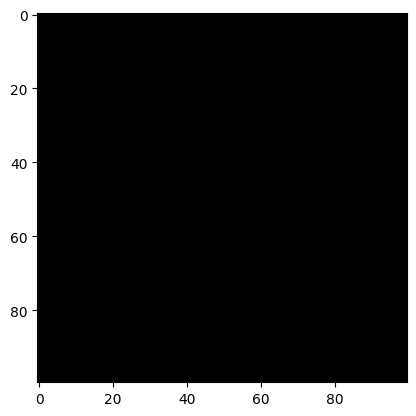

In [7]:
# Función para desnormalizar imágenes del rango [-1, 1] al rango [0, 1]
def denormalize(img):
    img = img * 0.5 + 0.5  # Desnormalizar al rango [0, 1]
    return img

# Función para mostrar una imagen
def show_image(img):
    img = denormalize(img)  # Desnormalizar la imagen
    npimg = img.numpy()  # Convertir a numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # Transponer para que los canales estén en el lugar correcto
    plt.show()

# Ejemplo de uso
# Obtener un lote de imágenes del DataLoader
data_iter = iter(data_loader)
images, _ = next(data_iter)

# Mostrar la primera imagen del lote
show_image(images[0])

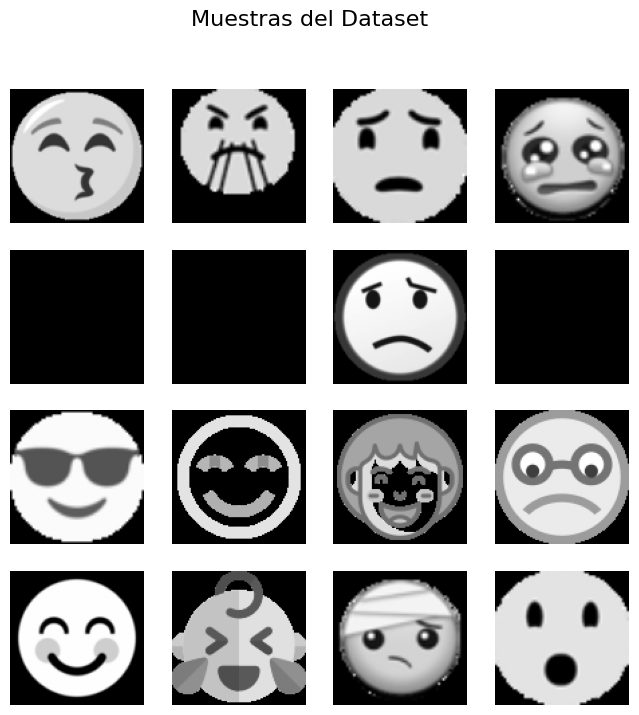

In [8]:
# Mostrar imágenes del dataset
def show_dataset_samples(data_loader):
    samples, _ = next(iter(data_loader)) # Obtener un lote de imágenes del DataLoader
    plt.figure(figsize=(8, 8)) # Crear una figura
    for i in range(16):
        plt.subplot(4, 4, i + 1) # Añadir un subplot de 4x4
        plt.imshow(samples[i][0].cpu().numpy(), cmap="gray") # Mostrar la imagen en escala de grises
        plt.axis("off")
    plt.suptitle("Muestras del Dataset", fontsize=16) 
    plt.show()

show_dataset_samples(data_loader)

In [9]:
# Definir el Generador
class Generator(nn.Module): 
    def __init__(self, latent_dim): # Recibe la dimensión del espacio latente como argumento
        super(Generator, self).__init__() 
        self.model = nn.Sequential( # Define la arquitectura del generador
            nn.Linear(latent_dim, 128), # Capa lineal de tamaño 'latent_dim' x 128
            nn.LeakyReLU(0.2, inplace=True), # Función de activación Leaky ReLU
            nn.Linear(128, 256), 
            nn.BatchNorm1d(256),   # Batch normalization
            nn.LeakyReLU(0.2, inplace=True), 
            nn.Linear(256, 512), # Capa lineal de tamaño 256 x 512
            nn.BatchNorm1d(512), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_size * img_size), 
            nn.Tanh() # Función de activación Tanh
        )

    def forward(self, z):
        img = self.model(z) # vector de ruido
        img = img.view(img.size(0), 1, img_size, img_size) # Redimensionar la salida al tamaño de imagen deseado
        return img

In [10]:
# Definir el Discriminador

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(     # Define la arquitectura del discriminador
            nn.Linear(img_size * img_size, 512), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1), # capa de salida 1 neurona
            nn.Sigmoid() # Función de activación Sigmoid para obtener una probabilidad
        )

    def forward(self, img): # Recibe una imagen y devuelve la probabilidad de que sea real
        img_flat = img.view(img.size(0), -1) # Aplanar la imagen
        validity = self.model(img_flat) # Obtener la probabilidad de que la imagen sea real
        return validity 

In [11]:
# Inicializar modelos de GAN
generator = Generator(latent_dim=100).to(device) # instancia del generador con vector de ruido de dimensión 100
discriminator = Discriminator().to(device) 
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, beta2))  # Optimizador Adam para el generador
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, beta2))
loss_function = nn.BCELoss() # Función de pérdida Binary Cross Entropy

In [12]:
# Modelo de difusión
class DiffusionModel(nn.Module): # 
    def __init__(self, img_size): 
        super(DiffusionModel, self).__init__()
        self.img_size = img_size
        self.model = nn.Sequential(    # Define la arquitectura del modelo de difusión
            nn.Conv2d(1, 64, 3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x) # Devuelve la salida del modelo de difusión que son las imagenes procesadas

In [13]:
# Funciones auxiliares para el modelo de difusión
def add_noise(images, t): # Añadir ruido gaussiano a las imágenes
    noise = torch.randn_like(images) * t # Generar ruido gaussiano con la misma forma que las imágenes
    return images + noise 

def denoise_step(model, noisy_images, t): # quitar el ruido de las imágenes
    return noisy_images - t * model(noisy_images)

# Inicializar modelo de difusión y optimizador
diffusion_model = DiffusionModel(img_size).to(device)
optimizer_diff = optim.Adam(diffusion_model.parameters(), lr=learning_rate, betas=(beta1, beta2)) # optimizador
loss_function_diff = nn.MSELoss() # error cuadrático medio para medir la diferencia entre las imágenes originales y las procesadas

In [14]:
# Entrenamiento
gan_losses = {"G": [], "D": []} # 
diffusion_losses = []  
for epoch in range(num_epochs): # bucle que recorrer las épocas de entrenamiento
    epoch_loss_diff = 0 # inicializar la pérdida de difusión para la época actual
    for i, (imgs, _) in enumerate(data_loader): # recorrer los datos del DataLoader
        imgs = imgs.to(device)

        # GAN: Entrenamiento del discriminador
        real_labels = torch.ones((imgs.size(0), 1), device=device) # etiquetas reales
        fake_labels = torch.zeros((imgs.size(0), 1), device=device) # etiquetas falsas

        real_loss = loss_function(discriminator(imgs), real_labels) # calcular la pérdida para imágenes reales

        z = torch.randn(imgs.size(0), 100, device=device) # generar ruido
        fake_imgs = generator(z)
        fake_loss = loss_function(discriminator(fake_imgs.detach()), fake_labels) # calcular la pérdida para imágenes generadas por el generador

        d_loss = real_loss + fake_loss
        optimizer_D.zero_grad() # reiniciar los gradientes
        d_loss.backward() # retropropagación
        optimizer_D.step()

        # GAN: Entrenamiento del generador
        gen_loss = loss_function(discriminator(fake_imgs), real_labels) # calcular la pérdida del generador
        optimizer_G.zero_grad()
        gen_loss.backward()
        optimizer_G.step()

        gan_losses["D"].append(d_loss.item())
        gan_losses["G"].append(gen_loss.item())

        # Difusión: Añadir ruido y denoising
        t = torch.rand(1).item() 
        noisy_imgs = add_noise(imgs, t) # añadir ruido a las imágenes
        denoised_imgs = denoise_step(diffusion_model, noisy_imgs, t)

        loss_diff = loss_function_diff(denoised_imgs, imgs) # calcular la pérdida de difusión
        epoch_loss_diff += loss_diff.item() # acumular la pérdida de difusión para la época actual

        optimizer_diff.zero_grad() # reiniciar los gradientes
        loss_diff.backward()
        optimizer_diff.step()

    avg_loss_diff = epoch_loss_diff / len(data_loader) # calcular la pérdida de difusión promedio para la época actual
    diffusion_losses.append(avg_loss_diff) # añadir la pérdida de difusión promedio a la lista de pérdidas
    print(f"Epoch {epoch + 1}/{num_epochs} | D Loss: {d_loss.item():.4f} | G Loss: {gen_loss.item():.4f} | Diffusion Loss: {avg_loss_diff:.4f}")

    # Guardar imágenes generadas por GAN cada 10 épocas
    if (epoch + 1) % 10 == 0:
        z = torch.randn(16, 100, device=device) # generar ruido
        gen_imgs = generator(z).cpu().detach().numpy()
        for idx, img in enumerate(gen_imgs):
            plt.imsave(f"{output_dir}/gan_epoch{epoch + 1}_img{idx + 1}.png", img[0], cmap='gray')

        noisy_imgs = noisy_imgs.cpu().detach().numpy() # convertir las imágenes con ruido a numpy array
        denoised_imgs = denoised_imgs.cpu().detach().numpy()  
        for idx, (noisy, denoised) in enumerate(zip(noisy_imgs[:5], denoised_imgs[:5])):
            plt.imsave(f"{output_dir}/diffusion_epoch{epoch + 1}_noisy{idx + 1}.png", noisy[0], cmap='gray')
            plt.imsave(f"{output_dir}/diffusion_epoch{epoch + 1}_denoised{idx + 1}.png", denoised[0], cmap='gray')

Epoch 1/200 | D Loss: 0.3490 | G Loss: 2.2664 | Diffusion Loss: 0.1918
Epoch 2/200 | D Loss: 0.2683 | G Loss: 3.3533 | Diffusion Loss: 0.0814
Epoch 3/200 | D Loss: 0.2252 | G Loss: 4.4568 | Diffusion Loss: 0.0439
Epoch 4/200 | D Loss: 0.1469 | G Loss: 4.8399 | Diffusion Loss: 0.0400
Epoch 5/200 | D Loss: 0.0548 | G Loss: 5.0317 | Diffusion Loss: 0.0415
Epoch 6/200 | D Loss: 5.4744 | G Loss: 2.6820 | Diffusion Loss: 0.0408
Epoch 7/200 | D Loss: 0.3320 | G Loss: 4.6558 | Diffusion Loss: 0.0512
Epoch 8/200 | D Loss: 1.7225 | G Loss: 1.1313 | Diffusion Loss: 0.0354
Epoch 9/200 | D Loss: 0.8036 | G Loss: 1.5332 | Diffusion Loss: 0.0360
Epoch 10/200 | D Loss: 1.2441 | G Loss: 0.7998 | Diffusion Loss: 0.0390
Epoch 11/200 | D Loss: 0.8385 | G Loss: 1.2342 | Diffusion Loss: 0.0367
Epoch 12/200 | D Loss: 1.2932 | G Loss: 0.8909 | Diffusion Loss: 0.0421
Epoch 13/200 | D Loss: 0.6670 | G Loss: 1.3117 | Diffusion Loss: 0.0334
Epoch 14/200 | D Loss: 0.8607 | G Loss: 1.3932 | Diffusion Loss: 0.0335
E

In [15]:
# Guardar modelos entrenados
torch.save(generator.state_dict(), os.path.join(model_dir, "generator_1-200-Epoch.pth"))
torch.save(discriminator.state_dict(), os.path.join(model_dir, "discriminator_1-200-Epoch.pth"))
torch.save(diffusion_model.state_dict(), os.path.join(model_dir, "diffusion_model_1-200-Epoch.pth"))

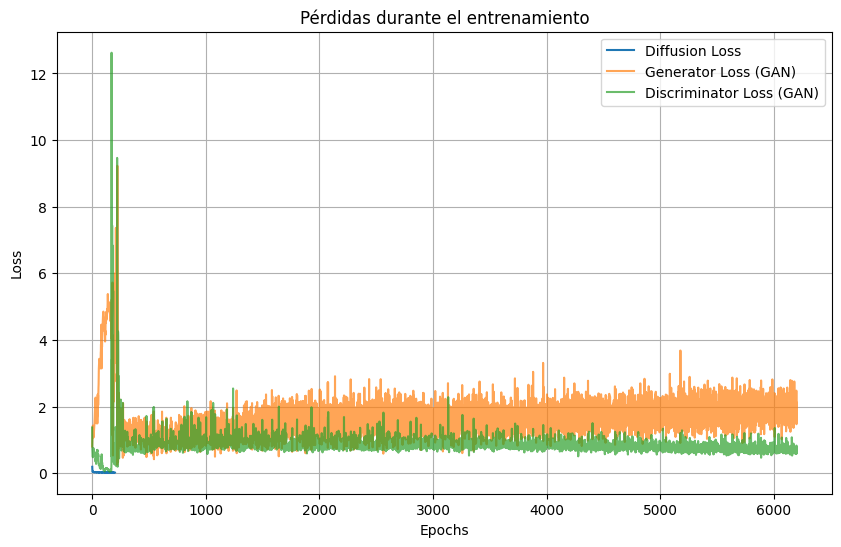

In [16]:
# Graficar pérdidas
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, diffusion_losses, label="Diffusion Loss")
plt.plot(range(len(gan_losses["G"])), gan_losses["G"], label="Generator Loss (GAN)", alpha=0.7)
plt.plot(range(len(gan_losses["D"])), gan_losses["D"], label="Discriminator Loss (GAN)", alpha=0.7)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Pérdidas durante el entrenamiento")
plt.legend()
plt.grid()
plt.show()

CARGANDO LOS MODELO YA ENTRENADO Y GENERAR IMAGENES

In [21]:
# Cargar modelos y generar imágenes
def load_models_and_generate():
    generator.load_state_dict(torch.load(os.path.join(model_dir, "generator_1-200-Epoch.pth")))
    generator.eval()

    discriminator.load_state_dict(torch.load(os.path.join(model_dir, "discriminator_1-200-Epoch.pth")))
    discriminator.eval()

    diffusion_model.load_state_dict(torch.load(os.path.join(model_dir, "diffusion_model_1-200-Epoch.pth")))
    diffusion_model.eval()

    # Generar imágenes con el generador
    z = torch.randn(16, 100, device=device)
    gen_imgs = generator(z).cpu().detach().numpy()
    plt.figure(figsize=(8, 8))
    for i, img in enumerate(gen_imgs):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[0], cmap="gray")
        plt.axis("off")
    plt.suptitle("Imágenes generadas por GAN", fontsize=16)
    plt.show()

    # Generar imágenes con el modelo de difusión
    imgs, _ = next(iter(data_loader))
    imgs = imgs.to(device)
    t = torch.rand(1).item()
    noisy_imgs = add_noise(imgs, t)
    denoised_imgs = denoise_step(diffusion_model, noisy_imgs, t).cpu().detach().numpy()

    plt.figure(figsize=(8, 4))
    for i in range(8):
        plt.subplot(2, 8, i + 1)
        plt.imshow(noisy_imgs[i][0].cpu().numpy(), cmap="gray")
        plt.axis("off")
        plt.subplot(2, 8, i + 9)
        plt.imshow(denoised_imgs[i][0], cmap="gray")
        plt.axis("off")
    plt.suptitle("Imágenes procesadas por el modelo de difusión", fontsize=16)
    plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_9012\3141670341.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(os.path.join(model_dir, "ge

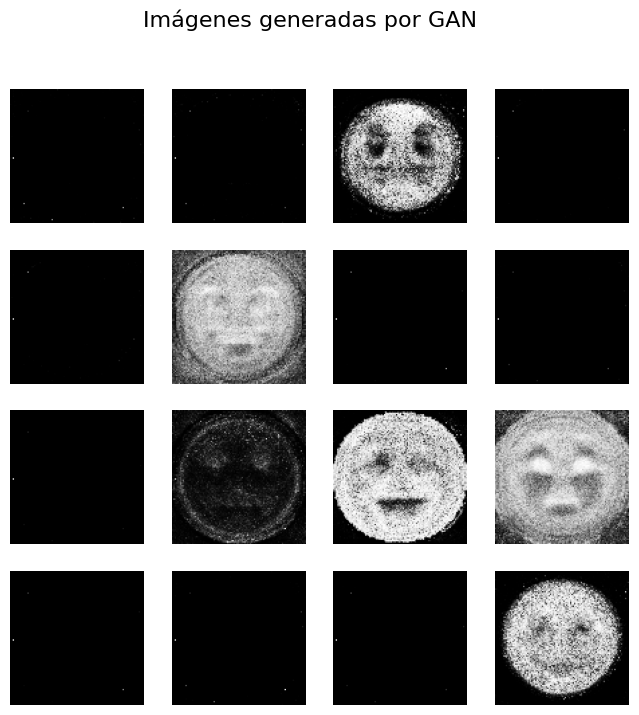

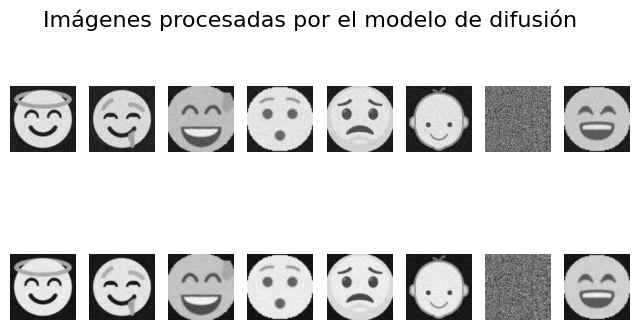

In [22]:
# Llamar a la función para cargar modelos y generar imágenes
load_models_and_generate()

In [19]:
#load_models_and_generate()